In [1]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.deprecated.doc2vec import LabeledSentence
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import STOPWORDS
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import metrics
#from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.multiclass import unique_labels

from collections import Counter
import matplotlib.pyplot as plt
import string
import re
import random
import glob
import itertools

np.random.seed(1234)
random.seed(1234)

porter = PorterStemmer()
punctuation_dictionary = {s:None for s in list(string.punctuation)}
punctuation_dictionary["-"] = "_"
punctuation_translator = str.maketrans(punctuation_dictionary)

def text_cleaner(text, punctuation_translator, stemmer):
    text = str(text).translate(punctuation_translator)
    text = text.lower()
    text = porter.stem(text)
    return(text)

## Load Speech & Clean

In [10]:
SubSpeech = pd.read_csv('SubSpeech_coded.csv')
SubSpeech.head()

,Unnamed: 0,Subspeech_index,SubContent,Speech_index,Candidate,Title,Date,Content,Type,URL,Year,Month,Day,Pop
0,0,Speech0_0:10,"['', ""PRESIDENT DONALD TRUMP: Thank you, thank...",Speech0,Donald J. Trump,"\nRemarks at a ""Make America Great Again"" Rall...","\nNovember 26, 2018","\nPRESIDENT DONALD TRUMP: Thank you, thank you...",Campaign Documents,/documents/remarks-make-america-great-again-ra...,2018,November,26,NaN
1,1,Speech0_10:20,['The unemployment rate just hit the lowest le...,Speech0,Donald J. Trump,"\nRemarks at a ""Make America Great Again"" Rall...","\nNovember 26, 2018","\nPRESIDENT DONALD TRUMP: Thank you, thank you...",Campaign Documents,/documents/remarks-make-america-great-again-ra...,2018,November,26,NaN
2,2,Speech0_20:30,"[""And I'll tell you, a little—a little tricky ...",Speech0,Donald J. Trump,"\nRemarks at a ""Make America Great Again"" Rall...","\nNovember 26, 2018","\nPRESIDENT DONALD TRUMP: Thank you, thank you...",Campaign Documents,/documents/remarks-make-america-great-again-ra...,2018,November,26,NaN
3,3,Speech0_30:40,"['You are here, he is here to help elect Cindy...",Speech0,Donald J. Trump,"\nRemarks at a ""Make America Great Again"" Rall...","\nNovember 26, 2018","\nPRESIDENT DONALD TRUMP: Thank you, thank you...",Campaign Documents,/documents/remarks-make-america-great-again-ra...,2018,November,26,NaN
4,4,Speech0_40:50,"[""What a great crowd we have tonight for you. ...",Speech0,Donald J. Trump,"\nRemarks at a ""Make America Great Again"" Rall...","\nNovember 26, 2018","\nPRESIDENT DONALD TRUMP: Thank you, thank you...",Campaign Documents,/documents/remarks-make-america-great-again-ra...,2018,November,26,NaN


In [11]:
SubSpeech["clean_text"] = SubSpeech["SubContent"].apply(lambda x: text_cleaner(x, punctuation_translator, porter))

In [16]:
#SubSpeech.head()

In [14]:
phrases1 = Phrases(map(lambda x: x.split(), SubSpeech["clean_text"].tolist()))
phrases2 = Phrases(phrases1[map(lambda x: x.split(), SubSpeech["clean_text"].tolist())])
SubSpeech["phrased_text"] = SubSpeech["clean_text"].apply(lambda x: " ".join(phrases2[phrases1[x.split()]]))

## Doc2Vev Model

In [17]:
docs = list(zip(SubSpeech["phrased_text"].tolist(), SubSpeech["Subspeech_index"].tolist()))


## Define an iterator to feed documents and tags to Doc2Vec
class Sentences(object):
  def __init__(self, docs):
    self.docs = docs
  def __iter__(self):
    for doc in self.docs:
      yield TaggedDocument(words=str(doc[0]).split(), tags=[doc[1]])

## Train and save models
model = Doc2Vec(Sentences(docs), vector_size=100, window=10, min_count=5, negative=10, epochs=20, dm=0, dbow_words=1)

In [18]:
model.wv.save_word2vec_format("doc2vec_wordvecs.txt", binary=False)

In [24]:
model.most_similar('democracy')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('oligarchy', 0.6355602145195007),
 ('democraci', 0.6329881548881531),
 ('democracies', 0.6227595210075378),
 ('civil_society', 0.6198344230651855),
 ('republic', 0.6092904806137085),
 ('human_rights', 0.6092815399169922),
 ('incite', 0.604902982711792),
 ('autocratic', 0.6041953563690186),
 ('most_powerful_force', 0.5965070724487305),
 ('self_determination', 0.5929067134857178)]

In [30]:
#Most similar phrase to populist doc
populist_index = list(set(SubSpeech.loc[SubSpeech['Pop'] == "accept", "Subspeech_index"].tolist()))
print(len(populist_index))
i = 0

value = SubSpeech.loc[SubSpeech['Subspeech_index']==populist_index[i]]["phrased_text"].tolist()
print(value)
model.wv.most_similar([model.docvecs[populist_index[i]]])

20
['everything you need to know about hillary_clinton can be understood with this simple but very_important phrase follow the money the large_corporations who support terrible_trade_deals that offshore jobs – they_are_donating to hillary_clinton follow the money the wall_street_investors who have rigged the regulations against the middle_class – they_are_donating to hillary_clinton follow the money the wealthy_donors who want to shut_down american energy – they_are_donating to hillary_clinton follow the money the special_interests who want open_borders are_donating to hillary_clinton again just follow the money in her campaign for president hillary_clinton has received 100_million dollars in contributions from wall_street and the hedge_fund']


[('they_are_donating', 0.8732218742370605),
 ('are_donating', 0.8328096270561218),
 ('wall_street_investors', 0.7575371265411377),
 ('wealthy_donors', 0.6677073240280151),
 ('large_corporations', 0.6174898743629456),
 ('everyday_americans', 0.6121031045913696),
 ('hedge_funds', 0.6065245270729065),
 ('terrible_trade_deals', 0.5971208214759827),
 ('jobs_overseas_–', 0.5858529806137085),
 ('breaking_up', 0.5806970000267029)]

## Classification

In [32]:
SubSpeech.Pop.replace('accept',1, inplace=True)

In [33]:
SubSpeech.Pop.replace('reject',0, inplace=True)

In [34]:
labelled_data = SubSpeech.loc[SubSpeech['Pop'].isin([0,1])][["Subspeech_index","Pop"]]
labelled_data = labelled_data.groupby(["Subspeech_index"]).mean()
print(labelled_data.head())
print(labelled_data.shape)

X = np.asarray([model.docvecs[i] for i in labelled_data.index.tolist()])
Y = np.asarray(labelled_data['Pop'].tolist(), dtype="int")

# ## Get the words most closely associated with all of the "populist" articles
# for k, v in model.most_similar(model.docvecs[populist_indices], topn=50):
#   print(k) 

kf = KFold(n_splits=5)
print(X.shape)
print(Y)

                  Pop
Subspeech_index      
Speech1482_0:10   0.0
Speech1482_10:20  0.0
Speech1482_20:30  0.0
Speech1482_30:42  0.0
Speech1515_0:10   0.0
(200, 1)
(200, 100)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AUC: 0.8457207207207207
Accuracy: 0.925
Mean AUC: 0.8457207207207207
Mean Accuracy: 0.925


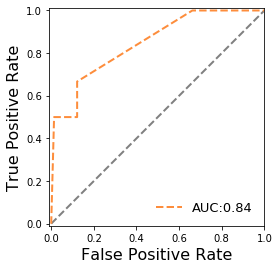

In [48]:
auc_scores_d2v = []
accuracy_scores_d2v = []

np.random.seed(1234) 
random.seed(1234)

plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['savefig.transparent'] = 'false'

plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.axes().set_aspect('equal')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
#plt.title('ROC curve', fontsize=16)
for i in range(1):
    ## Create a test and train set
    test_size = 80
    test_set = random.sample(range(0,len(Y)), test_size)
    train_set = list(set(list(range(0,len(Y)))) - set(test_set))
    ## Initialize a gradient boosting classifier
    gbc = RandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0, class_weight="balanced")
  # gbc = GradientBoostingClassifier(loss="deviance",
  #   learning_rate=0.1,
  #   n_estimators=20000,
  #   subsample=1.0,
  #   min_samples_split=2,
  #   min_samples_leaf=1,
  #   max_depth=4,
  #   init=None,
  #   random_state=None,
  #   max_features=None,
  #   verbose=0)
    gbc = CalibratedClassifierCV(gbc, cv=2, method="isotonic")
    ## Fit the model to the training set
    gbc.fit(X[np.asarray(train_set, dtype="int")], Y[np.asarray(train_set, dtype="int")])
    ## Predict out-of-sample on the test set and compute AUC
    preds = gbc.predict_proba(X[np.asarray(test_set, dtype="int")])
    fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(Y[np.asarray(test_set, dtype="int")], preds[:,1], pos_label=1)
    auc_scores_d2v = auc_scores_d2v + [metrics.auc(fpr_d2v, tpr_d2v)]
    plt.plot(fpr_d2v, tpr_d2v, lw=2, linestyle='--', label="AUC:" + str(metrics.auc(fpr_d2v, tpr_d2v))[0:4],color='#fd8d3c')
    print("AUC: "+str(metrics.auc(fpr_d2v, tpr_d2v)))
    accuracy_d2v = metrics.accuracy_score(Y[np.asarray(test_set, dtype="int")], gbc.predict(X[np.asarray(test_set, dtype="int")]), normalize=True)
    accuracy_scores_d2v = accuracy_scores_d2v + [accuracy_d2v]
    print("Accuracy: " + str(accuracy_d2v))
leg = plt.legend(framealpha = 0,loc='lower right', fontsize=13)
for text in leg.get_texts():
    plt.setp(text, color = 'black')
plt.savefig('images/d2v_rocs.png')
# vocab = model.wv.vocab.keys()
# vectors = [model[v] for v in vocab]
# vectors = np.asarray(vectors)

# word_preds = gbc.predict_proba(vectors)
# word_scores = dict(zip(vocab, word_preds[:,1].tolist()))
# sorted_keys = sorted(word_scores, key=word_scores.get, reverse=True)
# for r in sorted_keys[0:100]:
#     print(str(r))
print("Mean AUC: " + str(np.mean(auc_scores_d2v)))
print("Mean Accuracy: " + str(np.mean(accuracy_scores_d2v)))

In [60]:
predicted = gbc.predict(X[np.asarray(test_set, dtype="int")])
confusion = confusion_matrix(Y[np.asarray(test_set, dtype="int")], predicted)
print(confusion)

[[74  0]
 [ 6  0]]


In [69]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[74  0]
 [ 6  0]]


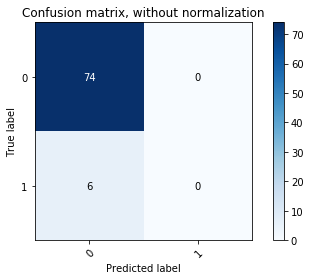

In [70]:
plot_confusion_matrix(Y[np.asarray(test_set, dtype="int")], predicted, 
                      title='Confusion matrix, without normalization')

In [72]:
scores = gbc.predict_proba(np.asarray([model.docvecs[a] for a in SubSpeech["Subspeech_index"]]))
predictions = gbc.predict(np.asarray([model.docvecs[a] for a in SubSpeech["Subspeech_index"]]))

In [73]:
SubSpeech["Pop_class"] = predictions.tolist()
SubSpeech["Pop_prob"] = scores[:,1].tolist()

In [75]:
SubSpeech["Pop_prob"].describe()

count    11929.000000
mean         0.111542
std          0.077663
min          0.043860
25%          0.043860
50%          0.111167
75%          0.111167
max          0.400641
Name: Pop_prob, dtype: float64

In [77]:
#SubSpeech.sort_values(by=['Pop_prob']).tail()

In [119]:
SubSpeech["Pop_class"] = [1 if x>=0.4 else 0 for x in SubSpeech["Pop_prob"]]

In [120]:
np.mean(SubSpeech["Pop_class"])

0.04501634671808199

Confusion matrix, without normalization
[[179   1]
 [  8  12]]


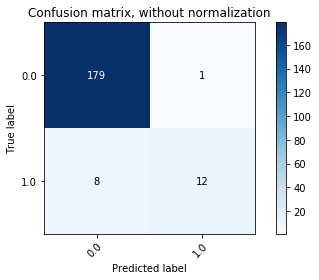

In [121]:
plot_confusion_matrix(SubSpeech.loc[SubSpeech['Pop'].isin([0,1])]["Pop"], 
                      SubSpeech.loc[SubSpeech['Pop'].isin([0,1])]["Pop_class"])

In [125]:
SubSpeech.to_csv('SubSpeech_predicted.csv', index=False)

## Blind Test (prodigy)

In [2]:
SubSpeech_predicted = pd.read_csv('SubSpeech_predicted.csv')

In [128]:
#SubSpeech_predicted.head()

In [133]:
virgintext = SubSpeech.loc[-SubSpeech['Pop'].isin([0,1])]

In [139]:
#virgintext.Subspeech_index[virgintext.Pop_class==1]

In [172]:
blind_index = list(np.random.choice(virgintext.Subspeech_index[virgintext.Pop_class==1], 10, replace=False)) + list(
    np.random.choice(virgintext.Subspeech_index[virgintext.Pop_class==0], 5, replace=False)) 

In [173]:
blindspeech_index = [re.split('_',x)[0] for x in blind_index]

In [174]:
blindspeech_sample = SubSpeech[['Speech_index', 'Subspeech_index','SubContent']].loc[
    SubSpeech.Speech_index.isin(blindspeech_index)]

In [175]:
blindspeech_sample['text'] = [blindspeech_sample.Subspeech_index[i] + '## ' + ''.join(blindspeech_sample.SubContent[i])
                           for i in blindspeech_sample.Subspeech_index.index]

In [176]:
len(blindspeech_sample.Subspeech_index)

126

In [177]:
blindspeech_sample.to_csv('blindspeech_sample.csv')

In [11]:
blindspeech_sample = pd.read_csv("blindspeech_sample.csv")

In [20]:
#SubSpeech_predicted.Candidate[SubSpeech_predicted.Speech_index.isin(blindspeech_sample.Speech_index)]

In [181]:
len(SubSpeech.Speech_index.loc[SubSpeech['Pop'].isin([0,1])].value_counts())

41

In [22]:
SubSpeech_predicted.loc[SubSpeech_predicted.Speech_index == "Speech146"]

,Unnamed: 0,Subspeech_index,SubContent,Speech_index,Candidate,Title,Date,Content,Type,URL,Year,Month,Day,Pop,clean_text,phrased_text,Pop_class,Pop_prob
1274,1274,Speech146_0:10,"['', 'Thank you for the opportunity to speak t...",Speech146,Donald J. Trump,\nRemarks on Foreign Policy \n,"\nApril 27, 2016",\nThank you for the opportunity to speak to yo...,Campaign Documents,/documents/remarks-foreign-policy,2016,April,27,NaN,thank you for the opportunity to speak to you...,thank_you for the opportunity to speak to you ...,0,0.321102
1275,1275,Speech146_10:20,"['First, our resources are totally over extend...",Speech146,Donald J. Trump,\nRemarks on Foreign Policy \n,"\nApril 27, 2016",\nThank you for the opportunity to speak to yo...,Campaign Documents,/documents/remarks-foreign-policy,2016,April,27,NaN,first our resources are totally over extended ...,first our resources are totally over extended ...,0,0.111167
1276,1276,Speech146_20:30,['When the other side knows you’re not going t...,Speech146,Donald J. Trump,\nRemarks on Foreign Policy \n,"\nApril 27, 2016",\nThank you for the opportunity to speak to yo...,Campaign Documents,/documents/remarks-foreign-policy,2016,April,27,NaN,when the other side knows you’re not going to ...,when the other_side knows you’re not going to ...,0,0.111167
1277,1277,Speech146_30:40,"['We’re a humanitarian nation, but the legacy ...",Speech146,Donald J. Trump,\nRemarks on Foreign Policy \n,"\nApril 27, 2016",\nThank you for the opportunity to speak to yo...,Campaign Documents,/documents/remarks-foreign-policy,2016,April,27,NaN,we’re a humanitarian nation but the legacy of ...,we’re a humanitarian nation but the legacy of ...,0,0.111167
1278,1278,Speech146_40:50,"['We should work — thank you. [Applause]', 'We...",Speech146,Donald J. Trump,\nRemarks on Foreign Policy \n,"\nApril 27, 2016",\nThank you for the opportunity to speak to yo...,Campaign Documents,/documents/remarks-foreign-policy,2016,April,27,NaN,we should work — thank you applause we should ...,we should work — thank_you applause we should ...,0,0.237557
1279,1279,Speech146_50:60,"['This will ensure that our own workers, right...",Speech146,Donald J. Trump,\nRemarks on Foreign Policy \n,"\nApril 27, 2016",\nThank you for the opportunity to speak to yo...,Campaign Documents,/documents/remarks-foreign-policy,2016,April,27,NaN,this will ensure that our own workers right he...,this will ensure that our own workers right_he...,0,0.043860
1280,1280,Speech146_60:70,['Some say the Russians won’t be reasonable. I...,Speech146,Donald J. Trump,\nRemarks on Foreign Policy \n,"\nApril 27, 2016",\nThank you for the opportunity to speak to yo...,Campaign Documents,/documents/remarks-foreign-policy,2016,April,27,NaN,some say the russians won’t be reasonable i in...,some say the russians won’t be reasonable i in...,0,0.127476
1281,1281,Speech146_70:80,['Our power will be used if others do not play...,Speech146,Donald J. Trump,\nRemarks on Foreign Policy \n,"\nApril 27, 2016",\nThank you for the opportunity to speak to yo...,Campaign Documents,/documents/remarks-foreign-policy,2016,April,27,NaN,our power will be used if others do not play b...,our power will be used if others do not play b...,0,0.111167
1282,1282,Speech146_80:91,['No country has ever prospered that failed to...,Speech146,Donald J. Trump,\nRemarks on Foreign Policy \n,"\nApril 27, 2016",\nThank you for the opportunity to speak to yo...,Campaign Documents,/documents/remarks-foreign-policy,2016,April,27,NaN,no country has ever prospered that failed to p...,no country has ever prospered that failed to p...,1,0.400641
